In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline

In [50]:
df_reddit = pd.read_csv('big_reddit_list.csv')

In [51]:
df_reddit.head()

,author,id,num_comments,score,created_utc,selftext,title,subreddit
0,nothanksbud5,g5rffm,1,2,1587516214,Wow i didn’t realize how much music is about b...,Why is almost all music seem to be about love?,CasualConversation
1,yungwhitedemon,g5re5u,1,1,1587516078,[removed],"If you’re spiritually, emotionally, mentally, ...",CasualConversation
2,Stock_Willingness,g5rcw2,0,1,1587515941,[removed],why does it feel like no one cares about you i...,CasualConversation
3,Infinitely_Chaotic,g5r85a,1,2,1587515438,[removed],"On the morning of my birthday, I woke up disap...",CasualConversation
4,dontknowwhattdo,g5r7z2,3,2,1587515419,I thought that during this time it would be ni...,pieces of advice that have stuck with you?,CasualConversation


In [52]:
df_reddit.shape

(30000, 8)

### Removing null values

In [53]:
df_reddit.isnull().sum()

author             0
id                 0
num_comments       0
score              0
created_utc        0
selftext        1402
title              0
subreddit          0
dtype: int64

In [54]:
df_reddit.dropna(inplace=True)

In [55]:
df_reddit.isnull().sum()

author          0
id              0
num_comments    0
score           0
created_utc     0
selftext        0
title           0
subreddit       0
dtype: int64

In [56]:
df_reddit.shape

(28598, 8)

In [57]:
# Checking to see the balance
df_reddit['subreddit'].value_counts(normalize=True)

CasualConversation     0.653018
SeriousConversation    0.346982
Name: subreddit, dtype: float64

In [58]:
# Checking to see how many values that have been [removed]
df_reddit.loc[df_reddit['selftext'] == '[removed]', :]

,author,id,num_comments,score,created_utc,selftext,title,subreddit
1,yungwhitedemon,g5re5u,1,1,1587516078,[removed],"If you’re spiritually, emotionally, mentally, ...",CasualConversation
2,Stock_Willingness,g5rcw2,0,1,1587515941,[removed],why does it feel like no one cares about you i...,CasualConversation
3,Infinitely_Chaotic,g5r85a,1,2,1587515438,[removed],"On the morning of my birthday, I woke up disap...",CasualConversation
7,Fatass_Pug,g5r45q,6,1,1587515006,[removed],"Black people, what can I do as a white guy to ...",CasualConversation
11,siel04,g5r2mu,1,1,1587514852,[removed],I'm having a lousy day. What's something funny...,CasualConversation
...,...,...,...,...,...,...,...,...
29981,CutenessIsJustice,fgiugx,1,1,1583866361,[removed],Is friendzone really bad?,CasualConversation
29987,bean_masters,fgij65,10,1,1583865179,[removed],Moving forward in life,CasualConversation
29993,StrictDependent1,fgi5cm,2,1,1583863709,[removed],Which Movie Should I Watch?,CasualConversation
29995,jontydruid,fgi4zy,0,1,1583863676,[removed],Elon musk probably has a micro penis,CasualConversation


In [59]:
# Deleting the selftext that has been [removed]
df_reddit = df_reddit[df_reddit['selftext'] != '[removed]']

In [60]:
# Checking to see the balance again after removing the [removed] values
df_reddit['subreddit'].value_counts(normalize=True)

CasualConversation     0.578923
SeriousConversation    0.421077
Name: subreddit, dtype: float64

In [72]:
df_reddit['subreddit'].value_counts()

CasualConversation     12635
SeriousConversation     9190
Name: subreddit, dtype: int64

In [64]:
df_reddit.shape

(21825, 8)

In [76]:
# Checking to see if there are any duplicates
df_reddit = df_reddit.drop_duplicates(subset=['id'])

In [77]:
df_reddit.shape

(21825, 8)

## Feature Engineering

In [93]:
# Creating columns with Character and Word counts to see if there is any difference between the two
df_reddit['char_count_title'] = df_reddit['title'].map(len)
df_reddit['word_count_title'] = df_reddit['title'].map(lambda x:len(x.split()))

df_reddit['char_count_selftext'] = df_reddit['selftext'].map(len)
df_reddit['word_count_selftext'] = df_reddit['selftext'].map(lambda x:len(x.split()))

In [95]:
df_reddit.groupby('subreddit').mean()

,num_comments,score,created_utc,char_count_title,word_count_title,char_count_selftext,word_count_selftext
subreddit,,,,,,,
CasualConversation,13.096795,13.935259,1.585582e+09,58.254294,10.897032,657.345706,123.359873
SeriousConversation,10.138955,9.349402,1.561567e+09,63.029271,11.754189,1361.125354,253.773232


In [96]:
# Creating a feature with title and selftext combined
# Checking to see how that will work in a model
df_reddit['title + selftext'] = df_reddit['title'] + ' ' + df_reddit['selftext']

In [98]:
# Changing CasualConversation = 0 & SeriousConversation = 1
df_reddit['subreddit'] = df_reddit['subreddit'].map({'CasualConversation': 0, 'SeriousConversation': 1})

In [99]:
df_reddit.head()

,author,id,num_comments,score,created_utc,selftext,title,subreddit,char_count_title,word_count_title,char_count_selftext,word_count_selftext,title + selftext
0,nothanksbud5,g5rffm,1,2,1587516214,Wow i didn’t realize how much music is about b...,Why is almost all music seem to be about love?,0,46,10,219,36,Why is almost all music seem to be about love?...
4,dontknowwhattdo,g5r7z2,3,2,1587515419,I thought that during this time it would be ni...,pieces of advice that have stuck with you?,0,42,8,285,55,pieces of advice that have stuck with you? I t...
5,sharkfinnsouphk,g5r5q2,2,0,1587515173,I just can't shake this worry about kids (and ...,Worried about people stuck at home,0,34,6,269,50,Worried about people stuck at home I just can'...
8,dehlen1me,g5r3t3,0,1,1587514972,https://youtu.be/9_AWrNmcMZA\nThis is one of t...,How a 5 Dollar bill can help you to feel bette...,0,62,13,179,24,How a 5 Dollar bill can help you to feel bette...
15,fighterpilot909,g5qtjo,2,2,1587513886,Imagine how insane that book would be. To make...,I want an autobiography from John McAfee so badly,0,49,9,144,28,I want an autobiography from John McAfee so ba...


## Data Visualization

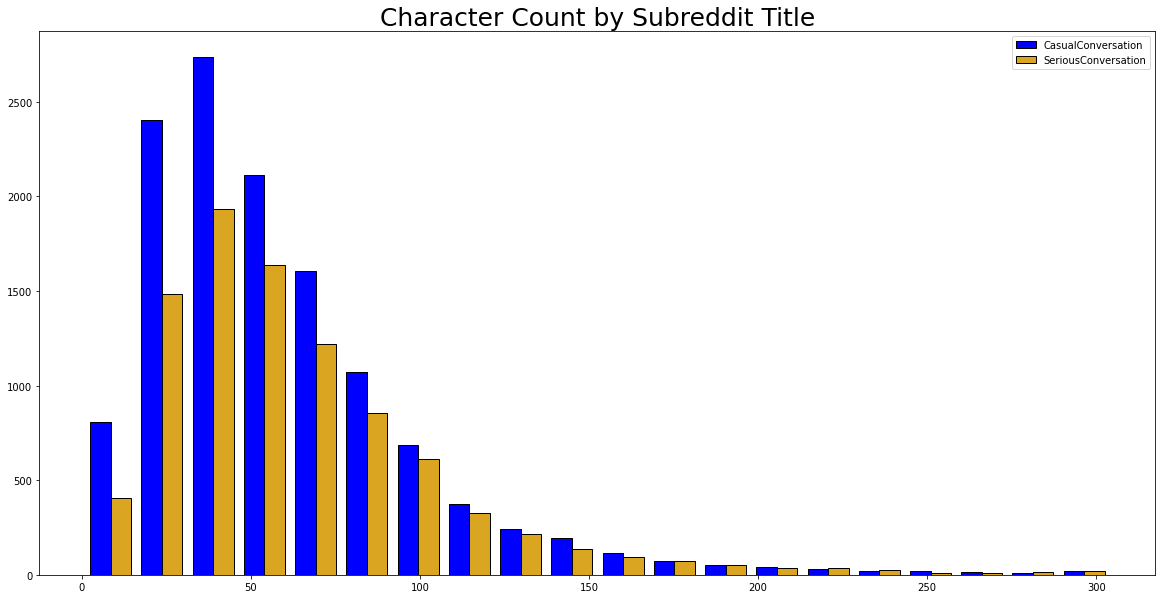

In [100]:
plt.figure(figsize=(20, 10))
plt.hist([df_reddit[df_reddit['subreddit'] == 0]['char_count_title'],
          df_reddit[df_reddit['subreddit'] == 1]['char_count_title']],
        bins=20, color=['blue', 'goldenrod'], ec='k')
plt.title('Character Count by Subreddit Title', fontsize=25)
plt.legend(['CasualConversation', 'SeriousConversation']);

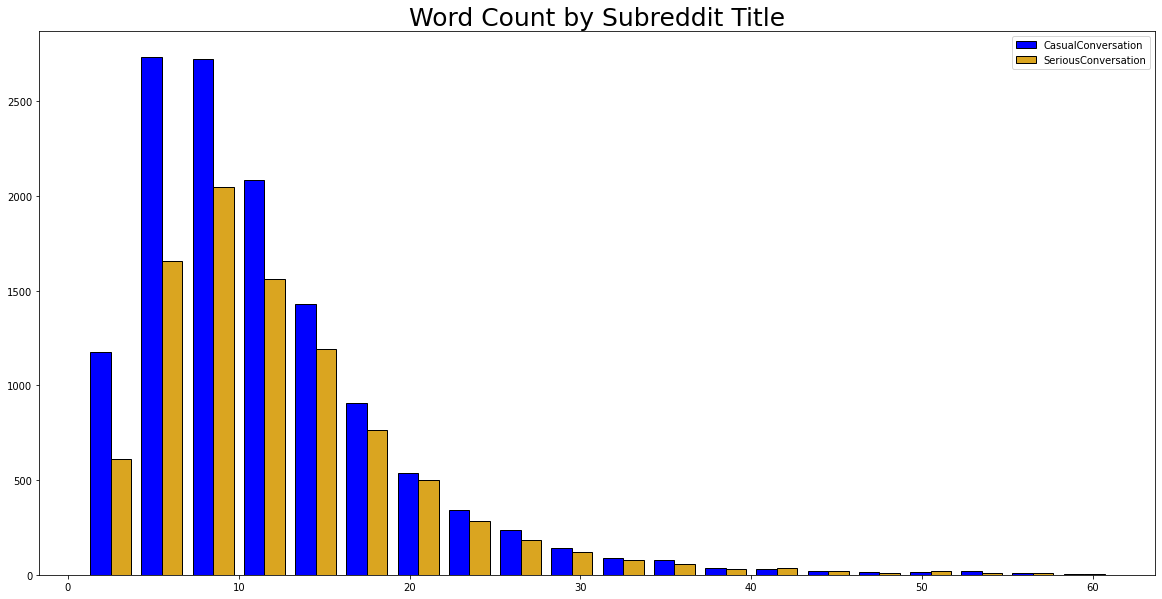

In [101]:
plt.figure(figsize=(20, 10))
plt.hist([df_reddit[df_reddit['subreddit'] == 0]['word_count_title'],
          df_reddit[df_reddit['subreddit'] == 1]['word_count_title']],
        bins=20, color=['blue', 'goldenrod'], ec='k')
plt.title('Word Count by Subreddit Title', fontsize=25)
plt.legend(['CasualConversation', 'SeriousConversation']);

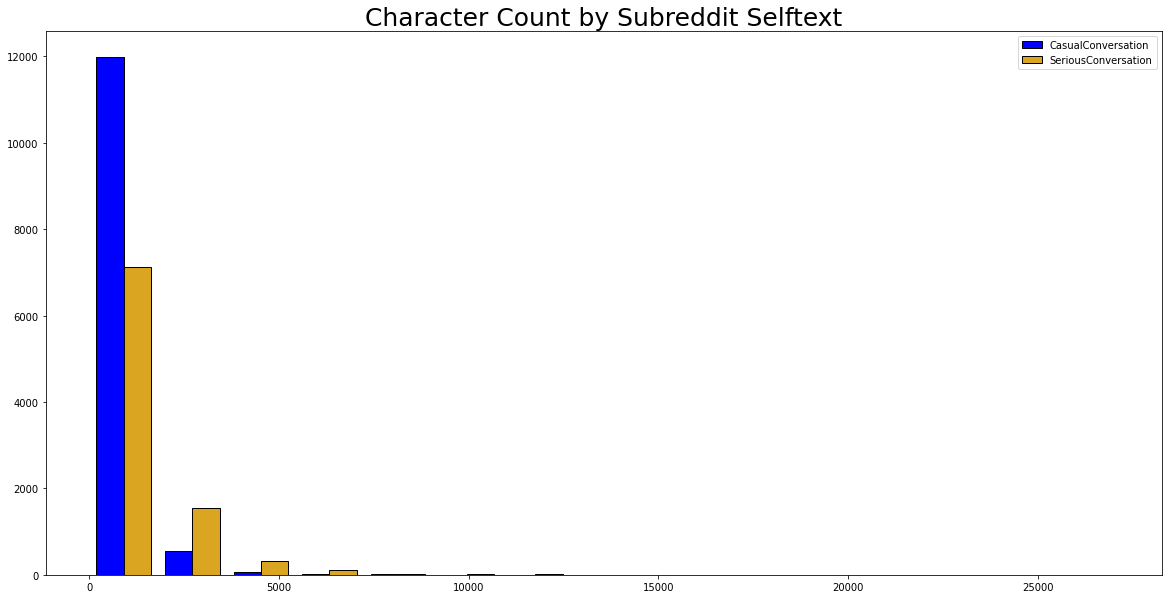

In [102]:
plt.figure(figsize=(20, 10))
plt.hist([df_reddit[df_reddit['subreddit'] == 0]['char_count_selftext'],
          df_reddit[df_reddit['subreddit'] == 1]['char_count_selftext']],
        bins=15, color=['blue', 'goldenrod'], ec='k')
plt.title('Character Count by Subreddit Selftext', fontsize=25)
plt.legend(['CasualConversation', 'SeriousConversation']);

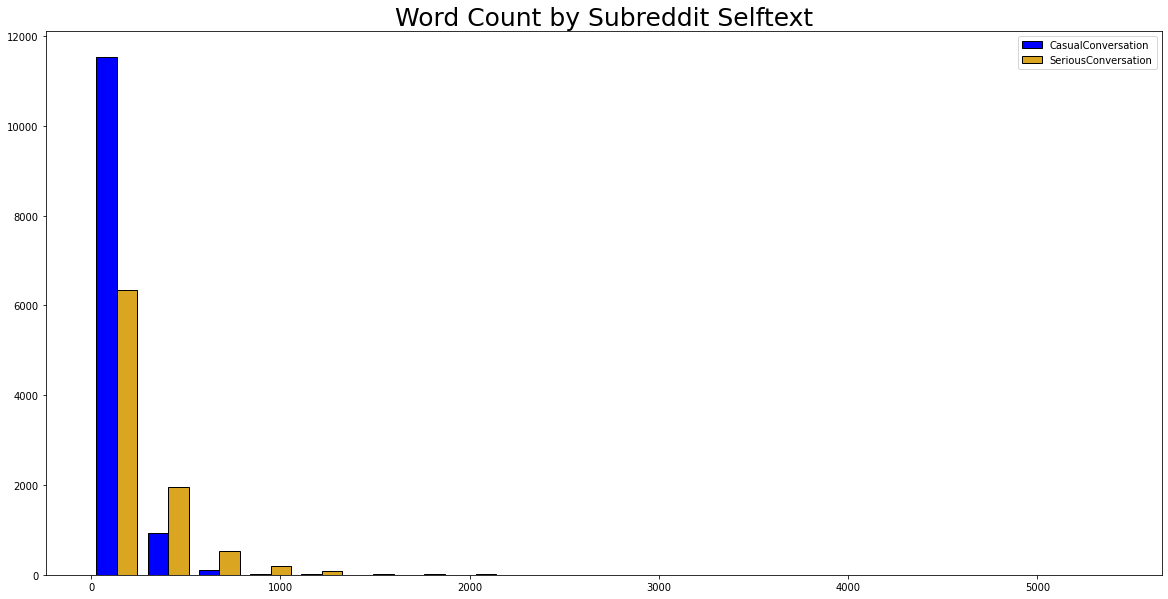

In [107]:
plt.figure(figsize=(20, 10))
plt.hist([df_reddit[df_reddit['subreddit'] == 0]['word_count_selftext'],
          df_reddit[df_reddit['subreddit'] == 1]['word_count_selftext']],
        bins=20, color=['blue', 'goldenrod'], ec='k')
plt.title('Word Count by Subreddit Selftext', fontsize=25)
plt.legend(['CasualConversation', 'SeriousConversation']);

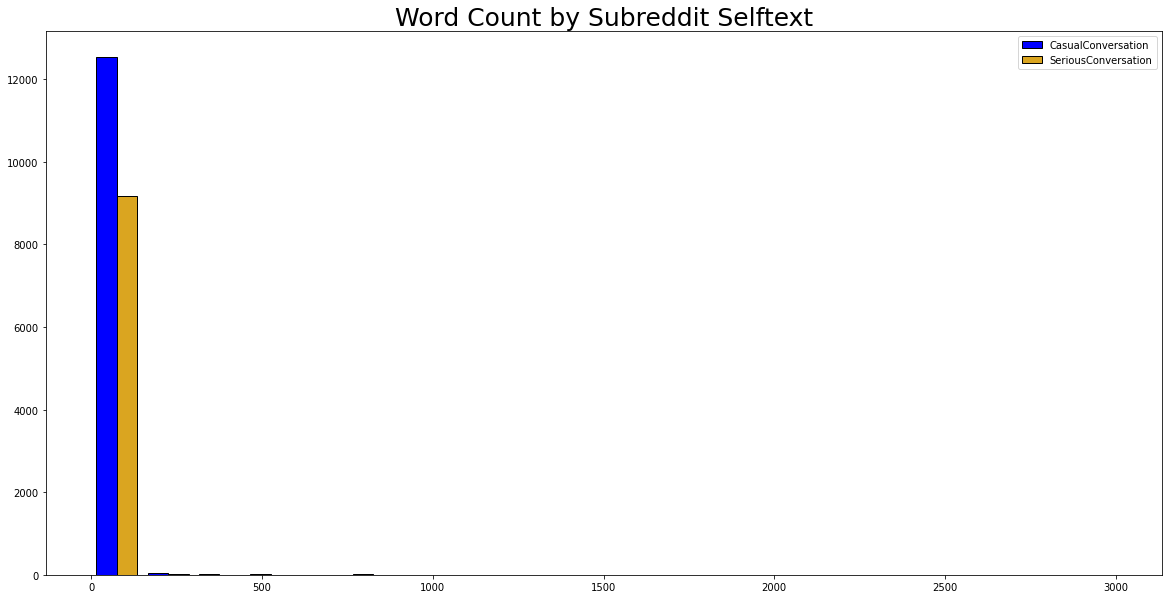

In [108]:
plt.figure(figsize=(20, 10))
plt.hist([df_reddit[df_reddit['subreddit'] == 0]['num_comments'],
          df_reddit[df_reddit['subreddit'] == 1]['num_comments']],
        bins=20, color=['blue', 'goldenrod'], ec='k')
plt.title('Word Count by Subreddit Selftext', fontsize=25)
plt.legend(['CasualConversation', 'SeriousConversation']);

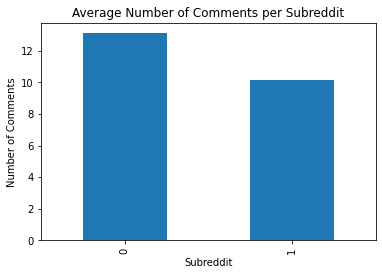

In [123]:
df_reddit.groupby('subreddit')['num_comments'].mean().plot(kind='bar')
plt.title('Average Number of Comments per Subreddit')
plt.ylabel('Number of Comments')
plt.xlabel('Subreddit');

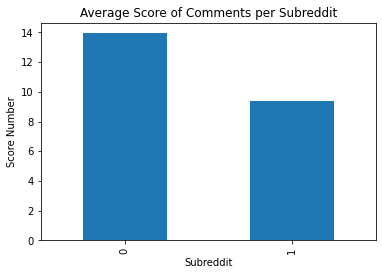

In [124]:
df_reddit.groupby('subreddit')['score'].mean().plot(kind='bar')
plt.title('Average Score of Comments per Subreddit')
plt.ylabel('Score Number')
plt.xlabel('Subreddit');

# Getting First Model

### Checking models on title and selftext separately

In [126]:
# Checking Title first
X = df_reddit['title']
y = df_reddit['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

In [127]:
# Checking my baseline
y_test.value_counts(normalize=True)

0    0.578889
1    0.421111
Name: subreddit, dtype: float64

In [128]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=5000))
])

pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df': [1, 2, 3 , 4],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)]
}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=5)

In [129]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [130]:
gs.best_score_

0.7284332427941465

In [131]:
gs.score(X_test, y_test)

0.737218251786696

In [132]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [133]:
# Checking selftext 
X = df_reddit['selftext']
y = df_reddit['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

In [134]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=5000))
])

pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)]
}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=5)

In [135]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [136]:
gs.best_score_

0.7852521911099142

In [137]:
gs.score(X_test, y_test)

0.7899945024738868